 Experiment: Analyzing Task-Role Representations in a Spatial Model
 
 This notebook tests the hypothesis that the model learns representations based on a location's functional role within a navigation task (i.e., whether a location is a START, END, or intermediate PATH node).
 
 1.  **Generate Task-Specific Prompts**: Create prompts that mimic the training data format (`MODE: ..., START: ..., END: ..., PATH: ...`).
 2.  **Extract Role-Based Embeddings**: Get the model's hidden states for each location and categorize them based on their role in the prompt.
 3.  **Visualize with PCA**: Use PCA to reduce the dimensionality of the embeddings and plot the results, coloring each point by its identified role (`start`, `end`, or `path`).
 
 A successful experiment will show three distinct clusters along the primary PCA axis, corresponding to the three roles.

In [51]:
# pip install --upgrade huggingface_hub 


In [52]:
# imports
import random
import string
import torch
import numpy as np
import networkx as nx
import logging
import os

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Set up logging to only show INFO level messages and higher
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Ensure the cache directory is set if running in a restricted environment
# os.environ["TRANSFORMERS_CACHE"] = "/path/to/your/cache"
# os.environ["HF_HOME"] = "/path/to/your/cache"



In [53]:

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define the paths to your models.
# Make sure the paths are correct for your environment.
model_paths = {
    "gpt2-base": "gpt2",
    "checkpoint-mid": "./spatial_model/checkpoint-22355",
    "checkpoint-final": "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/spatial_model/checkpoint-44659"
}



In [54]:
# %%
# =============================================================================
# CELL 3: CORE GPT AND HELPER UTILITIES
# =============================================================================

class GPTWrapper:
    """Handles loading the model and tokenizer and extracting hidden states."""
    def __init__(self, model_name='gpt2'):
        logging.info(f"Loading model: {model_name}")
        path = model_paths.get(model_name, model_name)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(path)
        self.model = GPT2LMHeadModel.from_pretrained(path, output_hidden_states=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        logging.info("Model and tokenizer loaded successfully.")

    def get_hidden_states_with_offsets(self, prompt, layer_idx):
        enc = self.tokenizer(prompt,
                             return_tensors="pt",
                             truncation=True,
                             return_offsets_mapping=True)
        with torch.no_grad():
            out = self.model(**enc)
        hidden_states = out.hidden_states[layer_idx].squeeze(0).detach().numpy()
        offsets = enc["offset_mapping"][0].tolist()
        return hidden_states, offsets

def substring_positions(haystack, needle):
    """Finds all start and end positions of a substring in a string."""
    result = []
    start = 0
    while True:
        idx = haystack.find(needle, start)
        if idx == -1:
            break
        result.append([idx, idx + len(needle)])
        start = idx + 1
    return result

def gather_embeddings_for_span(offsets, hidden_states, span):
    """Averages the embeddings of tokens that overlap with a given character span."""
    (start_needed, end_needed) = span
    overlap_vecs = []
    for i, (start_off, end_off) in enumerate(offsets):
        # Check if token span overlaps with the desired character span
        if not (end_off <= start_needed or start_off >= end_needed):
            overlap_vecs.append(hidden_states[i])
    if not overlap_vecs:
        return None
    return np.mean(overlap_vecs, axis=0)



In [55]:
# %%
# =============================================================================
# CELL 4: GRAPH, PROMPT, AND ROLE-BASED EMBEDDING EXTRACTION
# =============================================================================

# def generate_name() -> str:
#     """Generates a random two-character name for a node."""
#     return ''.join(random.choices(string.ascii_lowercase, k=2))

from wonderwords import RandomWord
rw = RandomWord()
def generate_name() -> str:
    name = rw.word(include_parts_of_speech=["noun"])
    return name

def get_grid_graph_3x3(nodes=None):
    """Creates a 3x3 directed grid graph."""
    if nodes is None:
        nodes = [generate_name() for _ in range(9)]
    G = nx.DiGraph()
    # Edges defined as (row, col) indices
    grid_indices = np.arange(9).reshape(3,3)
    for r in range(3):
        for c in range(3):
            current_node = nodes[grid_indices[r,c]]
            G.add_node(current_node)
            if c < 2: # East
                neighbor = nodes[grid_indices[r, c+1]]
                G.add_edge(current_node, neighbor, direction='R')
                G.add_edge(neighbor, current_node, direction='L')
            if r < 2: # South
                neighbor = nodes[grid_indices[r+1, c]]
                G.add_edge(current_node, neighbor, direction='D')
                G.add_edge(neighbor, current_node, direction='U')
    return G, nodes

def build_positions_3x3(node_names):
    """Maps node names to (row, col) grid coordinates."""
    return {node_names[i]: (i // 3, i % 3) for i in range(9)}

def get_topological_role(position):
    """Determines the topological role (corner, edge, center) from grid position."""
    r, c = position
    if (r, c) == (1, 1): return 'center'
    if r in {0, 2} and c in {0, 2}: return 'corner'
    return 'edge'

def generate_single_task_prompt(G, node_names, mode="Shortest"):
    """Generates a single prompt in the training format: 'START...END...PATH...'"""
    start_node, end_node = random.sample(node_names, 2)
    try:
        path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
    except nx.NetworkXNoPath:
        return None, None

    path_str_parts = []
    for i in range(len(path_nodes) - 1):
        u, v = path_nodes[i], path_nodes[i+1]
        direction = G.edges[(u, v)]['direction']
        path_str_parts.append(u)
        path_str_parts.append(direction)
    path_str_parts.append(end_node)
    
    path_as_string = " ".join(path_str_parts)
    prompt = f"MODE: {mode}, START: {start_node}, END: {end_node}, PATH: {path_as_string}"
    
    # Return the path nodes to easily identify roles
    return prompt, path_nodes

def generate_single_task_prompt(G, node_names, mode="Foraging"):
    """Generates a single prompt in the training format: 'START...END...PATH...'."""
    
    if mode is None:
        mode = random.choice(["Shortest", "Foraging"])
        
    start_node, end_node = random.sample(node_names, 2)

    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
        except nx.NetworkXNoPath:
            return None, None
    else:  # Foraging
        path_nodes = [start_node]
        current_node = start_node
        for _ in range(random.randint(10, 20)):
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break
            if len(path_nodes) > 1 and len(neighbors) > 1:
                neighbors = [n for n in neighbors if n != path_nodes[-2]]
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        end_node = path_nodes[-1]

    path_str_parts = []
    for i in range(len(path_nodes) - 1):
        u, v = path_nodes[i], path_nodes[i+1]
        direction = G.edges.get((u, v), {}).get('direction', 'NA')  # Default to '?' if missing
        path_str_parts.append(u)
        path_str_parts.append(direction)
    path_str_parts.append(end_node)

    path_as_string = " ".join(path_str_parts)
    prompt = f"MODE: {mode}, START: {start_node}, END: {end_node}, PATH: {path_as_string}"

    return prompt, path_nodes


def gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states):
    """
    Gathers embeddings for locations and categorizes them by their role
    in the prompt (start, end, path).
    """
    loc_embeddings_by_role = {'start': {}, 'end': {}, 'path': {}}
    start_node, end_node = path_nodes[0], path_nodes[-1]
    
    for i, loc in enumerate(path_nodes):
        # Determine the role of the current location in the path
        if i == 0:
            role = 'start'
        elif i == len(path_nodes) - 1:
            role = 'end'
        else:
            role = 'path'
        
        # This simplified approach assumes each location name appears once in the path string
        # which is true for a shortest path.
        pos_list = substring_positions(prompt, loc)
        
        # We need to find the correct occurrence (e.g., in `START: aa` vs `PATH: ... aa ...`)
        # For simplicity, we'll just average all mentions if a name repeats, but for shortest
        # paths, names are unique.
        found_vecs = []
        for s, e in pos_list:
            emb = gather_embeddings_for_span(offsets, hidden_states, (s, e))
            if emb is not None:
                found_vecs.append(emb)

        if found_vecs:
            # Check if this location already has an embedding for this role (unlikely but possible)
            if loc not in loc_embeddings_by_role[role]:
                loc_embeddings_by_role[role][loc] = []
            loc_embeddings_by_role[role][loc].extend(found_vecs)

    # Average the collected embeddings
    averaged_embeddings = {}
    for role, locs in loc_embeddings_by_role.items():
        averaged_embeddings[role] = {loc: np.mean(vecs, axis=0) for loc, vecs in locs.items()}

    return averaged_embeddings



In [56]:
# %%
# =============================================================================
# CELL 5: PLOTTING FUNCTION
# =============================================================================

def plot_role_based_pca(all_points, model_name, reducer="pca"):
    """
    Performs PCA on the collected embeddings and plots the results,
    colored by the location's role in the prompt.
    """
    if not all_points:
        logging.error("No data to plot.")
        return

    logging.info(f"Plotting role-based {reducer.upper()} for {model_name}.")

    X = np.array([pt['vector'] for pt in all_points])
    
    if reducer.lower() == "pca":
        dim_red = PCA(n_components=2)
    else:
        from umap import UMAP
        dim_red = UMAP(n_components=2, random_state=42)
        
    X_2d = dim_red.fit_transform(X)

    # Add 2D coordinates back to the points list
    for i, coords in enumerate(X_2d):
        all_points[i]['x2d'], all_points[i]['y2d'] = coords[0], coords[1]
    
    # Setup for plotting
    plt.figure(figsize=(10, 8))
    
    grouping_key = 'prompt_role'
    groups = ['start', 'path', 'end']
    color_map = {'start': '#2ca02c', 'path': '#1f77b4', 'end': '#d62728'} # Green, Blue, Red
    legend_title = "Role in Prompt"

    legend_handles = []

    # Plot KDEs and scatter points for each role
    for group in groups:
        role_points = [p for p in all_points if p[grouping_key] == group]
        if not role_points:
            continue

        xs = [p['x2d'] for p in role_points]
        ys = [p['y2d'] for p in role_points]
        color = color_map[group]

        # Use seaborn for Kernel Density Estimation plots
        if len(role_points) > 1:
            sns.kdeplot(x=xs, y=ys, fill=True, color=color, alpha=0.2, linewidth=0)
        
        plt.scatter(xs, ys, color=color, alpha=0.7, s=30, label=group.capitalize())
        
        legend_handles.append(mpatches.Patch(color=color, label=group.capitalize()))

    plt.title(f'PCA of Location Embeddings by Task Role ({model_name})', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(handles=legend_handles, title=legend_title, fontsize=12)
    plt.tight_layout()
    
    filename = f'{model_name}_role_based_{reducer}.png'
    plt.savefig(filename, dpi=300)
    logging.info(f"Saved role-based plot as {filename}")
    plt.show()




In [57]:
# %%
# =============================================================================
# CELL 6: MAIN ANALYSIS FUNCTION
# =============================================================================

def run_role_based_analysis(
    model_name="checkpoint-final",
    layer_idx=6,
    num_prompts=300,
    reducer="pca"
):
    """Main function to run the entire role-based analysis pipeline."""
    logging.info(f"Starting role-based analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 50 == 0:
            logging.info(f"Processing prompt {i+1}/{num_prompts}...")
            
        # 1. Generate a new graph and a task-specific prompt
        G, node_names = get_grid_graph_3x3()
        prompt, path_nodes = generate_single_task_prompt(G, node_names)
        if not prompt:
            continue
            
        # 2. Get hidden states
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        
        # 3. Get embeddings categorized by role
        loc_mean_repr_by_role = gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states)

        # 4. Store the results for plotting
        grid_positions_mapping = build_positions_3x3(node_names)
        for role, loc_means in loc_mean_repr_by_role.items():
            for node_name, vec in loc_means.items():
                grid_pos = grid_positions_mapping[node_name]
                d = {
                    'prompt_idx': i,
                    'node_name': node_name,
                    'vector': vec,
                    'grid_position': grid_pos,
                    'topological_role': get_topological_role(grid_pos),
                    'prompt_role': role, # The crucial category
                }
                all_points.append(d)

    # 5. Plot the final results
    plot_role_based_pca(all_points, model_name, reducer=reducer)
    
    logging.info("Role-based analysis completed.")

    return all_points





In [58]:
# %%
# =============================================================================
# CELL 7: PLOTTING FUNCTION BY GRID POSITION
# =============================================================================

def plot_by_grid_position(all_points, model_name, reducer="pca"):
    """
    Plots the existing PCA data, but colors each point by its
    (row, col) grid coordinate to visualize the model's spatial map.
    
    Args:
        all_points (list): The list of data points, which must already
                           contain the 2D coordinates from a previous PCA run.
        model_name (str): The name of the model for the plot title.
        reducer (str): The name of the reducer used (for the title).
    """
    if not all_points or 'x2d' not in all_points[0]:
        logging.error("No data or no 2D coordinates found. Please run the main analysis first.")
        return

    logging.info(f"Plotting {reducer.upper()} for {model_name}, colored by grid coordinate.")
    
    plt.figure(figsize=(12, 9))
    
    # Use the grid_position as the key for grouping and coloring
    grouping_key = 'grid_position'
    
    # Sort the unique coordinates to ensure a consistent legend order
    # The `eval` call correctly sorts tuples like (0, 0), (0, 1), (1, 0)
    unique_coords = sorted(list(set(p[grouping_key] for p in all_points)), key=lambda c: eval(str(c)))
    
    # Use a colormap that provides distinct colors for up to 10 categories
    cmap = plt.get_cmap("tab10")
    color_map = {coord: cmap(i) for i, coord in enumerate(unique_coords)}
    legend_title = "Grid Coordinate (Row, Col)"

    # Plot each coordinate group with its assigned color
    for coord in unique_coords:
        # Filter points that match the current coordinate
        indices = [i for i, p in enumerate(all_points) if p[grouping_key] == coord]
        if not indices:
            continue
            
        xs = [all_points[i]['x2d'] for i in indices]
        ys = [all_points[i]['y2d'] for i in indices]
        
        plt.scatter(xs, ys, 
                    color=color_map[coord], 
                    alpha=0.7, 
                    s=40, 
                    label=str(coord))

    plt.title(f'{reducer.upper()} of Location Embeddings by Grid Coordinate ({model_name})', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Place the legend outside the plot area for better visibility
    plt.legend(title=legend_title, fontsize=10, bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    
    filename = f'{model_name}_pca_colored_by_grid_coordinate.png'
    plt.savefig(filename, dpi=300)
    logging.info(f"Saved grid position plot as {filename}")
    plt.show()

2025-07-14 01:03:49,036 - INFO - Starting role-based analysis for model: checkpoint-final
2025-07-14 01:03:49,038 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-14 01:03:49,268 - INFO - Model and tokenizer loaded successfully.
2025-07-14 01:03:51,388 - INFO - Processing prompt 50/300...
2025-07-14 01:03:53,542 - INFO - Processing prompt 100/300...
2025-07-14 01:03:55,671 - INFO - Processing prompt 150/300...
2025-07-14 01:

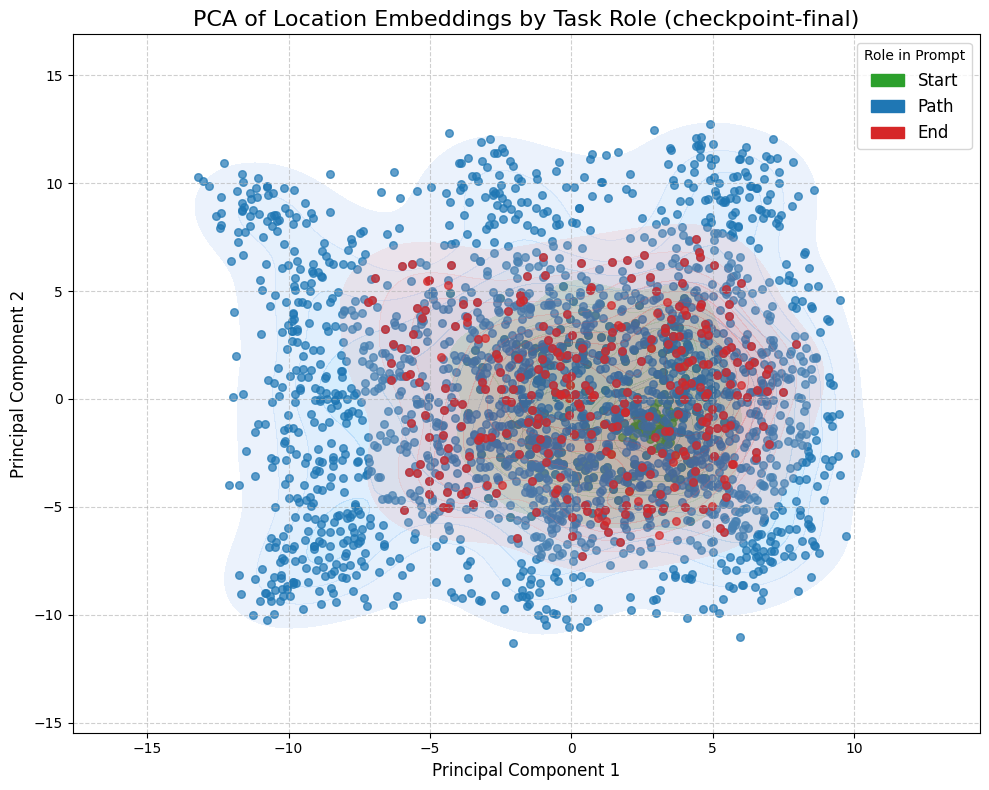

2025-07-14 01:04:04,529 - INFO - Role-based analysis completed.
2025-07-14 01:04:04,550 - INFO - Plotting PCA for checkpoint-final, colored by grid coordinate.
2025-07-14 01:04:05,565 - INFO - Saved grid position plot as checkpoint-final_pca_colored_by_grid_coordinate.png


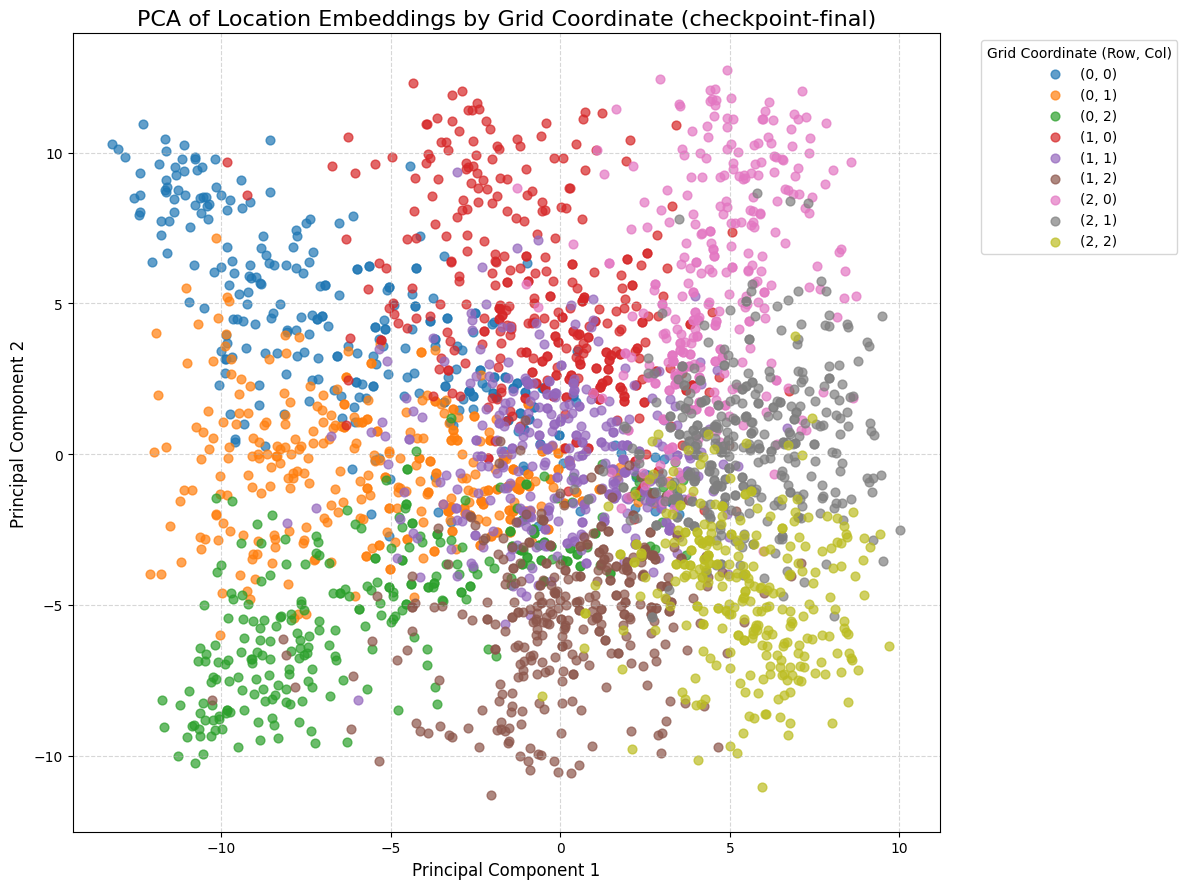

In [59]:
# %%
# note here that data is shortest path only

if __name__ == "__main__":
    # Select the model you want to test
    model_to_analyze = "checkpoint-final"
    
    # First, run the main analysis to get the 'all_points' data structure
    # This will also generate the first plot colored by task role.
    # We capture the returned `all_points` list.
    all_points_data = run_role_based_analysis(
        model_name=model_to_analyze,
        layer_idx=6,
        num_prompts=300,
        reducer="pca"
    )

    # Now, use the data from the previous run to create the second plot
    # This is efficient as it reuses the already computed PCA results.
    if all_points_data:
        plot_by_grid_position(
            all_points=all_points_data,
            model_name=model_to_analyze,
            reducer="pca"
        )

In [ ]:
# ANALYSIS 2: Colouring by path mode and positional role

def generate_task_prompt(G, node_names, mode=None):
    """Generates a single prompt in the training format: 'START...END...PATH...'."""
    
    if mode is None:
        mode = random.choice(["Shortest", "Foraging"])
        
    start_node, end_node = random.sample(node_names, 2)

    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
        except nx.NetworkXNoPath:
            return None, None
    else:  # Foraging
        path_nodes = [start_node]
        current_node = start_node
        for _ in range(random.randint(10, 20)):
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break
            if len(path_nodes) > 1 and len(neighbors) > 1:
                neighbors = [n for n in neighbors if n != path_nodes[-2]]
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        end_node = path_nodes[-1]

    path_str_parts = []
    for i in range(len(path_nodes) - 1):
        u, v = path_nodes[i], path_nodes[i+1]
        direction = G.edges.get((u, v), {}).get('direction', 'NA')  # Default to '?' if missing
        path_str_parts.append(u)
        path_str_parts.append(direction)
    path_str_parts.append(end_node)

    path_as_string = " ".join(path_str_parts)
    prompt = f"MODE: {mode}, START: {start_node}, END: {end_node}, PATH: {path_as_string}"

    return prompt, path_nodes, mode




def plot_by_property(all_points, model_name, reducer="pca", color_by='task_mode'):
    """
    Performs PCA/UMAP and plots the results, colored by a specified property.
    'color_by' can be 'task_mode', 'positional_role', etc.
    """
    if not all_points:
        logging.error("No data to plot.")
        return

    logging.info(f"Plotting {reducer.upper()} for {model_name}, colored by '{color_by}'.")

    X = np.array([pt['vector'] for pt in all_points])
    
    if reducer.lower() == "pca":
        dim_red = PCA(n_components=2)
    else:
        # UMAP is an alternative, often better for non-linear structures
        from umap import UMAP
        dim_red = UMAP(n_components=2, random_state=42)
        
    X_2d = dim_red.fit_transform(X)

    # Add the new 2D coordinates back to our list of dictionaries
    for i, coords in enumerate(X_2d):
        all_points[i]['x2d'], all_points[i]['y2d'] = coords[0], coords[1]
    
    plt.figure(figsize=(12, 8))
    
    # --- Dynamic Coloring Logic ---
    grouping_key = color_by
    groups = sorted(list(set(pt[grouping_key] for pt in all_points)))
    
    # Choose a color scheme based on the property we're plotting
    if color_by == 'task_mode':
        color_map = {'Shortest': '#1f77b4', 'Foraging': '#ff7f0e'} # Blue, Orange
        legend_title = "Task Mode"
    elif color_by == 'positional_role':
        color_map = {'First': '#2ca02c', 'Intermediate': '#d62728', 'End': '#9467bd'} # Green, Red, Purple
        legend_title = "Positional Role in Path"
    else: # A generic fallback for any other property
        cmap = plt.get_cmap("viridis")
        color_map = {group: cmap(i / len(groups)) for i, group in enumerate(groups)}
        legend_title = grouping_key.replace('_', ' ').title()
    # --- End of Dynamic Coloring Logic ---

    # Plot the points, one group at a time
    for group in groups:
        group_points = [p for p in all_points if p.get(grouping_key) == group]
        if not group_points: continue

        xs = [p['x2d'] for p in group_points]
        ys = [p['y2d'] for p in group_points]
        color = color_map.get(group)
        
        plt.scatter(xs, ys, color=color, alpha=0.6, s=25, label=str(group))

    plt.title(f'PCA of Location Embeddings by {legend_title} ({model_name})', fontsize=16)
    plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
    plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    # Place legend outside the plot for clarity
    plt.legend(title=legend_title, fontsize=12, bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    
    filename = f'{model_name}_pca_colored_by_{color_by}.png'
    plt.savefig(filename, dpi=300)
    logging.info(f"Saved plot as {filename}")
    plt.show()

def run_full_analysis(
    model_name="checkpoint-final",
    layer_idx=6,
    num_prompts=400,
    reducer="pca"
):
    logging.info(f"Starting full analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 50 == 0: logging.info(f"Processing prompt {i+1}/{num_prompts}...")
            
        G, node_names = get_grid_graph_3x3()
        # Generate a prompt with a random mode
        prompt, path_nodes, mode = generate_task_prompt(G, node_names)
        if not prompt: continue
            
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        
        # Use the existing role-based extraction
        loc_mean_repr_by_role = gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states)

        grid_positions_mapping = build_positions_3x3(node_names)
        
        # Store results with the new properties
        for role_in_header, loc_means in loc_mean_repr_by_role.items():
            for node_name, vec in loc_means.items():
                
                # Determine positional role in path
                try:
                    idx = path_nodes.index(node_name)
                    if idx == 0: positional_role = "First"
                    elif idx == len(path_nodes) - 1: positional_role = "End"
                    else: positional_role = "Intermediate"
                except ValueError:
                    positional_role = "Unknown"

                d = {
                    'vector': vec,
                    'task_mode': mode,                 # HYPOTHESIS 1
                    'positional_role': positional_role # HYPOTHESIS 2
                }
                all_points.append(d)

    # Plot the results twice, colored by each new property
    plot_by_property(all_points, model_name, reducer=reducer, color_by='task_mode')
    plot_by_property(all_points, model_name, reducer=reducer, color_by='positional_role')
    
    logging.info("Full analysis completed.")

2025-07-14 01:04:05,882 - INFO - Starting full analysis for model: checkpoint-final
2025-07-14 01:04:05,883 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-14 01:04:06,082 - INFO - Model and tokenizer loaded successfully.
2025-07-14 01:04:07,990 - INFO - Processing prompt 50/400...
2025-07-14 01:04:09,931 - INFO - Processing prompt 100/400...
2025-07-14 01:04:11,797 - INFO - Processing prompt 150/400...
2025-07-14 01:04:13,

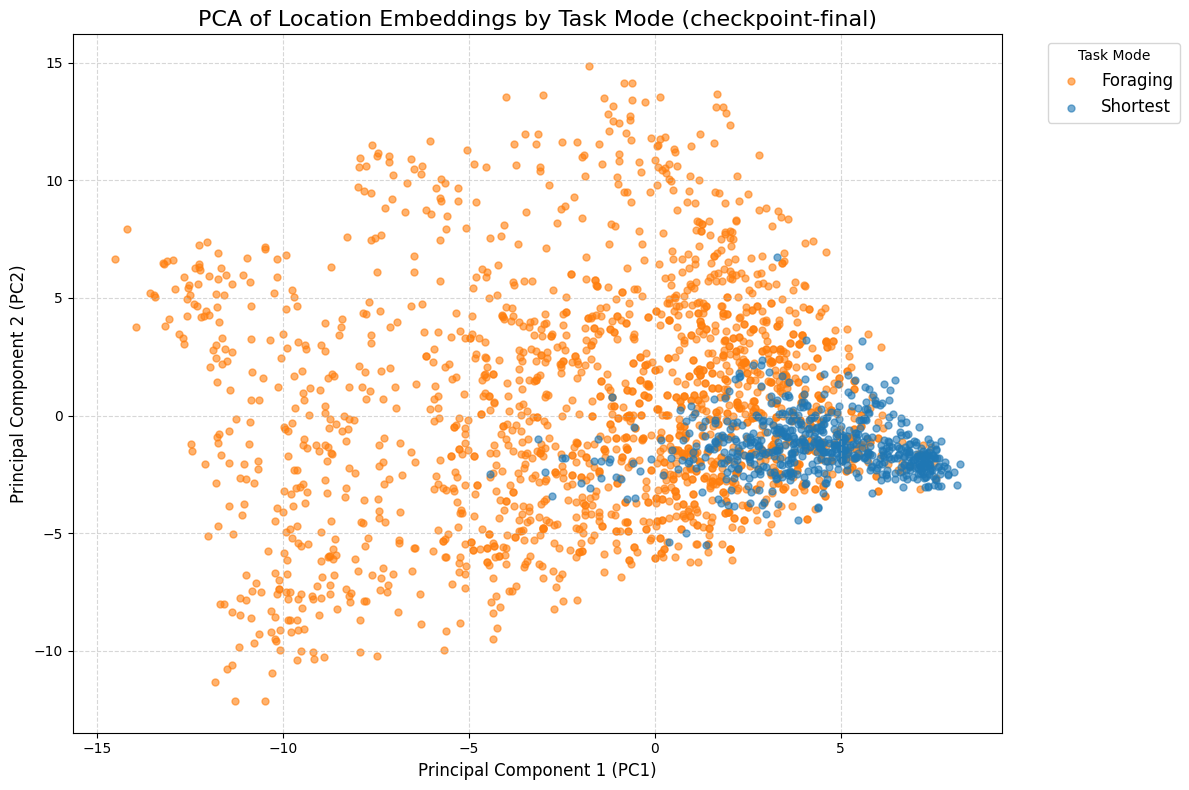

2025-07-14 01:04:22,401 - INFO - Plotting PCA for checkpoint-final, colored by 'positional_role'.
2025-07-14 01:04:23,306 - INFO - Saved plot as checkpoint-final_pca_colored_by_positional_role.png


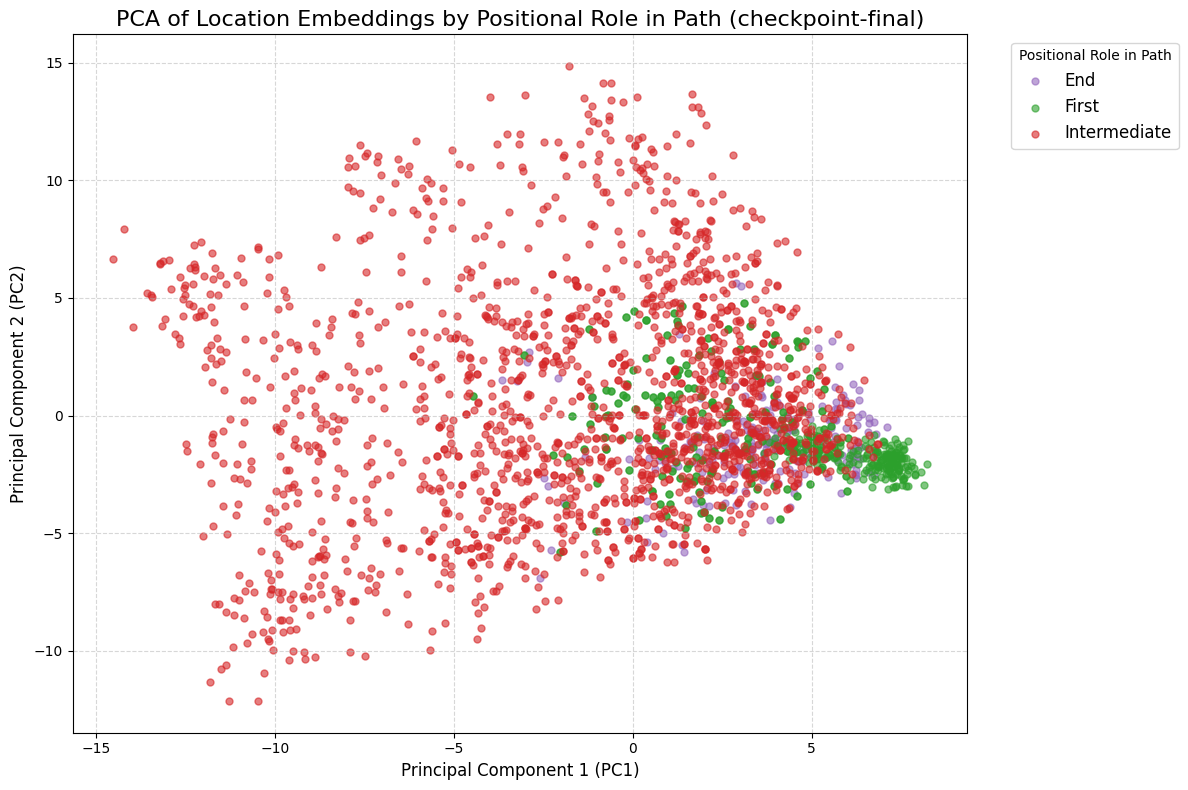

2025-07-14 01:04:23,464 - INFO - Full analysis completed.


In [61]:

if __name__ == "__main__":
    model_to_analyze = "checkpoint-final"
    run_full_analysis(
        model_name=model_to_analyze,
        layer_idx=6,
        num_prompts=400,
        reducer="pca"
    )

In [62]:
# In CELL 3, update this function.

def gather_embeddings_for_span(offsets, hidden_states, span):
    """
    Averages the embeddings of tokens that overlap with a given character span.
    Also returns the average index of the overlapping tokens.
    """
    (start_needed, end_needed) = span
    overlap_vecs = []
    overlap_indices = [] # <-- NEW: List to store token indices
    
    for i, (start_off, end_off) in enumerate(offsets):
        if not (end_off <= start_needed or start_off >= end_needed):
            overlap_vecs.append(hidden_states[i])
            overlap_indices.append(i) # <-- NEW: Add the token's index

    if not overlap_vecs:
        return None, None # <-- NEW: Return None for both values
        
    averaged_vec = np.mean(overlap_vecs, axis=0)
    average_idx = np.mean(overlap_indices) # <-- NEW: Calculate the average index
    
    return averaged_vec, average_idx # <-- NEW: Return both values# In CELL 4, update this function.

def gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states):
    """
    Gathers embeddings and their average token indices for locations, categorized by role.
    """
    # This structure now needs to hold both the vector and its index
    loc_data_by_role = {'start': {}, 'end': {}, 'path': {}}
    
    for i, loc in enumerate(path_nodes):
        role = 'start' if i == 0 else 'end' if i == len(path_nodes) - 1 else 'path'
        
        pos_list = substring_positions(prompt, loc)
        
        found_data = []
        for s, e in pos_list:
            # The updated function returns two values
            emb, avg_idx = gather_embeddings_for_span(offsets, hidden_states, (s, e))
            if emb is not None:
                # Store a tuple of (embedding, average_index)
                found_data.append((emb, avg_idx))

        if found_data:
            if loc not in loc_data_by_role[role]:
                loc_data_by_role[role][loc] = []
            loc_data_by_role[role][loc].extend(found_data)

    # Average the collected embeddings and indices separately
    averaged_data = {}
    for role, locs in loc_data_by_role.items():
        averaged_data[role] = {}
        for loc, data_list in locs.items():
            # Unzip the list of (vector, index) tuples
            vecs, idxs = zip(*data_list)
            # Average the vectors and indices
            avg_vec = np.mean(vecs, axis=0)
            avg_idx = np.mean(idxs)
            averaged_data[role][loc] = (avg_vec, avg_idx)

    return averaged_data

# In CELL 4, update this function.

def gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states):
    """
    Gathers embeddings and their average token indices for locations, categorized by role.
    """
    # This structure now needs to hold both the vector and its index
    loc_data_by_role = {'start': {}, 'end': {}, 'path': {}}
    
    for i, loc in enumerate(path_nodes):
        role = 'start' if i == 0 else 'end' if i == len(path_nodes) - 1 else 'path'
        
        pos_list = substring_positions(prompt, loc)
        
        found_data = []
        for s, e in pos_list:
            # The updated function returns two values
            emb, avg_idx = gather_embeddings_for_span(offsets, hidden_states, (s, e))
            if emb is not None:
                # Store a tuple of (embedding, average_index)
                found_data.append((emb, avg_idx))

        if found_data:
            if loc not in loc_data_by_role[role]:
                loc_data_by_role[role][loc] = []
            loc_data_by_role[role][loc].extend(found_data)

    # Average the collected embeddings and indices separately
    averaged_data = {}
    for role, locs in loc_data_by_role.items():
        averaged_data[role] = {}
        for loc, data_list in locs.items():
            # Unzip the list of (vector, index) tuples
            vecs, idxs = zip(*data_list)
            # Average the vectors and indices
            avg_vec = np.mean(vecs, axis=0)
            avg_idx = np.mean(idxs)
            averaged_data[role][loc] = (avg_vec, avg_idx)

    return averaged_data

# In CELL 6, update the main analysis function.

def run_full_analysis(
    model_name="checkpoint-final",
    layer_idx=6,
    num_prompts=400,
    reducer="pca"
):
    logging.info(f"Starting full analysis (including token index) for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 50 == 0: logging.info(f"Processing prompt {i+1}/{num_prompts}...")
            
        G, node_names = get_grid_graph_3x3()
        prompt, path_nodes, mode = generate_task_prompt(G, node_names)
        if not prompt: continue
            
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        
        # This now returns a more complex dictionary
        loc_data_by_role = gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states)

        for role_in_header, loc_data in loc_data_by_role.items():
            # loc_data now contains tuples: (vector, average_index)
            for node_name, (vec, avg_idx) in loc_data.items():
                
                try: # Determine positional role
                    path_idx = path_nodes.index(node_name)
                    positional_role = "First" if path_idx == 0 else "End" if path_idx == len(path_nodes) - 1 else "Intermediate"
                except ValueError:
                    positional_role = "Unknown"

                d = {
                    'vector': vec,
                    'task_mode': mode,
                    'positional_role': positional_role,
                    'token_index': avg_idx # <-- NEW: The housekeeping variable
                }
                all_points.append(d)

    # Plot colored by our new housekeeping variable
    plot_by_property(all_points, model_name, reducer=reducer, color_by='token_index')
    
    logging.info("Full analysis completed.")

    # In CELL 5, replace the plotting function with this final version.

def plot_by_property(all_points, model_name, reducer="pca", color_by='token_index'):
    """
    Performs PCA/UMAP and plots the results.
    Can color by discrete properties (like 'task_mode') or a
    continuous property (like 'token_index').
    """
    if not all_points:
        logging.error("No data to plot.")
        return

    logging.info(f"Plotting {reducer.upper()} for {model_name}, colored by '{color_by}'.")

    X = np.array([pt['vector'] for pt in all_points])
    
    if reducer.lower() == "pca":
        dim_red = PCA(n_components=2)
    else:
        from umap import UMAP
        dim_red = UMAP(n_components=2, random_state=42)
        
    X_2d = dim_red.fit_transform(X)

    plt.figure(figsize=(13, 8))
    
    # --- Check if the property is continuous or discrete ---
    # Heuristic: if more than 10 unique values, treat as continuous
    is_continuous = len(set(p[color_by] for p in all_points)) > 10

    if is_continuous:
        # --- Continuous Plotting Logic (for token_index) ---
        colors = [p[color_by] for p in all_points]
        legend_title = color_by.replace('_', ' ').title()
        
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, cmap='viridis', alpha=0.7, s=25)
        
        # Add a color bar to show the mapping from color to value
        cbar = plt.colorbar(scatter)
        cbar.set_label(legend_title, fontsize=12)

    else:
        # --- Discrete Plotting Logic (for task_mode, etc.) ---
        grouping_key = color_by
        groups = sorted(list(set(pt[grouping_key] for pt in all_points)))

        if color_by == 'task_mode':
            color_map = {'Shortest': '#1f77b4', 'Foraging': '#ff7f0e'}
            legend_title = "Task Mode"
        elif color_by == 'positional_role':
            color_map = {'First': '#2ca02c', 'Intermediate': '#d62728', 'End': '#9467bd'}
            legend_title = "Positional Role in Path"
        else: # Fallback
            cmap = plt.get_cmap("tab10")
            color_map = {group: cmap(i % 10) for i, group in enumerate(groups)}
            legend_title = grouping_key.replace('_', ' ').title()

        for group in groups:
            group_points = [i for i, p in enumerate(all_points) if p.get(grouping_key) == group]
            if not group_points: continue
            
            plt.scatter(X_2d[group_points, 0], X_2d[group_points, 1], 
                        color=color_map.get(group), alpha=0.6, s=25, label=str(group))
        
        plt.legend(title=legend_title, fontsize=12, bbox_to_anchor=(1.04, 1), loc='upper left')

    plt.title(f'PCA of Location Embeddings by {color_by.replace("_", " ").title()} ({model_name})', fontsize=16)
    plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
    plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    filename = f'{model_name}_pca_colored_by_{color_by}.png'
    plt.savefig(filename, dpi=300)
    logging.info(f"Saved plot as {filename}")
    plt.show()

2025-07-14 01:04:23,553 - INFO - Starting full analysis (including token index) for model: checkpoint-final
2025-07-14 01:04:23,553 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-14 01:04:23,746 - INFO - Model and tokenizer loaded successfully.
2025-07-14 01:04:25,676 - INFO - Processing prompt 50/400...
2025-07-14 01:04:27,588 - INFO - Processing prompt 100/400...
2025-07-14 01:04:29,470 - INFO - Processing prompt 150/400

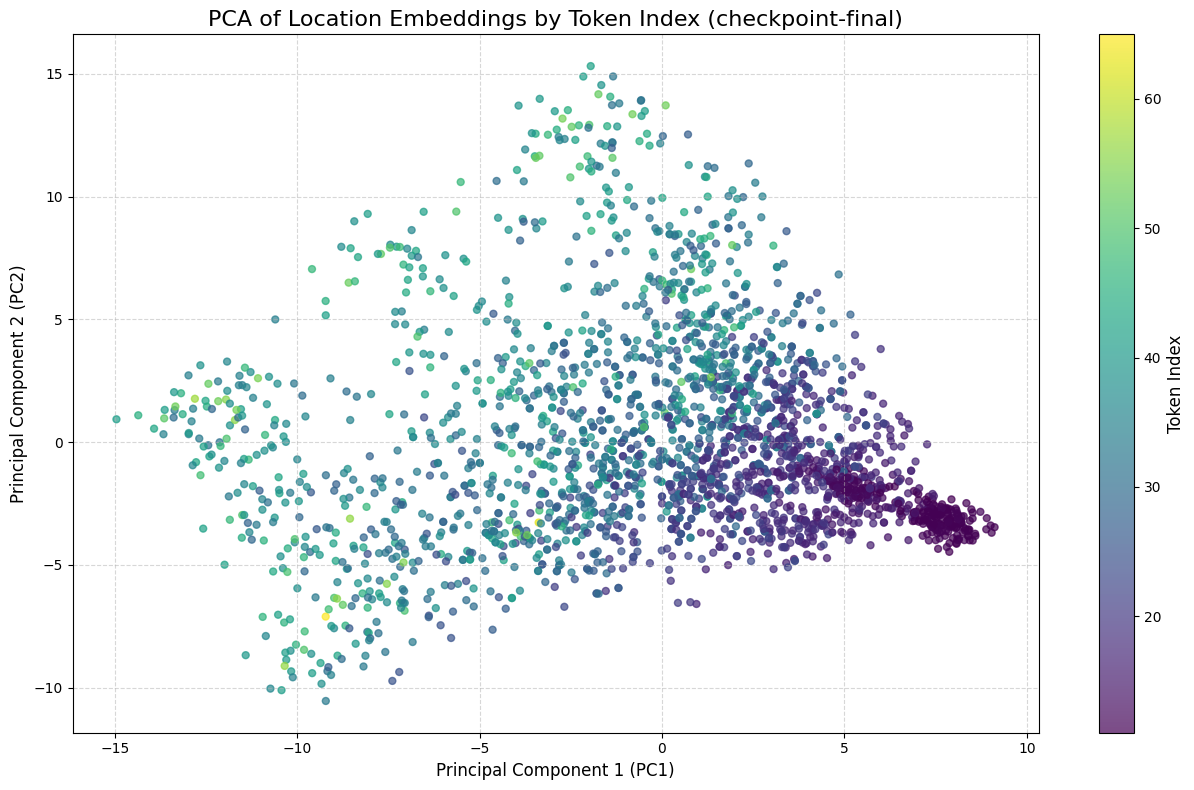

2025-07-14 01:04:40,211 - INFO - Full analysis completed.


In [63]:
if __name__ == "__main__":
    model_to_analyze = "checkpoint-final"
    run_full_analysis(
        model_name=model_to_analyze,
        layer_idx=6,
        num_prompts=400, # Use a good number of prompts
        reducer="pca"
    )


 Final Experiment: Uncovering the Latent Structure of Task Representation
 
 This notebook conducts a definitive experiment to explain the three-band structure observed in the PCA plots.
 
 **Hypothesis**: The primary axis of variance (PC1) is not a single property, but a composite representation of **task complexity**. This complexity is a function of both the `Task Mode` (`Shortest` vs. `Foraging`) and the `Manhattan Distance` between the start and end nodes.
 
 **Method**:
 1.  Generate a mix of `Shortest` and `Foraging` path prompts.
 2.  For each prompt, calculate the Manhattan Distance between the start and end goals.
 3.  Create a new, combined categorical variable: `mode_distance` (e.g., "Shortest-Dist-2").
 4.  Perform PCA on the embeddings of all locations mentioned in the prompts.
 5.  Visualize the PCA result, coloring each point by its `mode_distance` to see if this property aligns with the three vertical bands.



2025-07-14 01:04:40,266 - INFO - Starting full analysis for model: checkpoint-final
2025-07-14 01:04:40,266 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-14 01:04:40,441 - INFO - Model and tokenizer loaded successfully.


2025-07-14 01:04:42,231 - INFO - Processing prompt 50/600...
2025-07-14 01:04:44,112 - INFO - Processing prompt 100/600...
2025-07-14 01:04:45,993 - INFO - Processing prompt 150/600...
2025-07-14 01:04:47,841 - INFO - Processing prompt 200/600...
2025-07-14 01:04:49,660 - INFO - Processing prompt 250/600...
2025-07-14 01:04:51,533 - INFO - Processing prompt 300/600...
2025-07-14 01:04:53,438 - INFO - Processing prompt 350/600...
2025-07-14 01:04:55,393 - INFO - Processing prompt 400/600...
2025-07-14 01:04:57,338 - INFO - Processing prompt 450/600...
2025-07-14 01:04:59,152 - INFO - Processing prompt 500/600...
2025-07-14 01:05:01,030 - INFO - Processing prompt 550/600...
2025-07-14 01:05:02,891 - INFO - Processing prompt 600/600...
2025-07-14 01:05:02,924 - INFO - Plotting PCA for checkpoint-final, colored by 'mode_distance'.
2025-07-14 01:05:04,189 - INFO - Saved plot as checkpoint-final_pca_colored_by_mode_distance.png


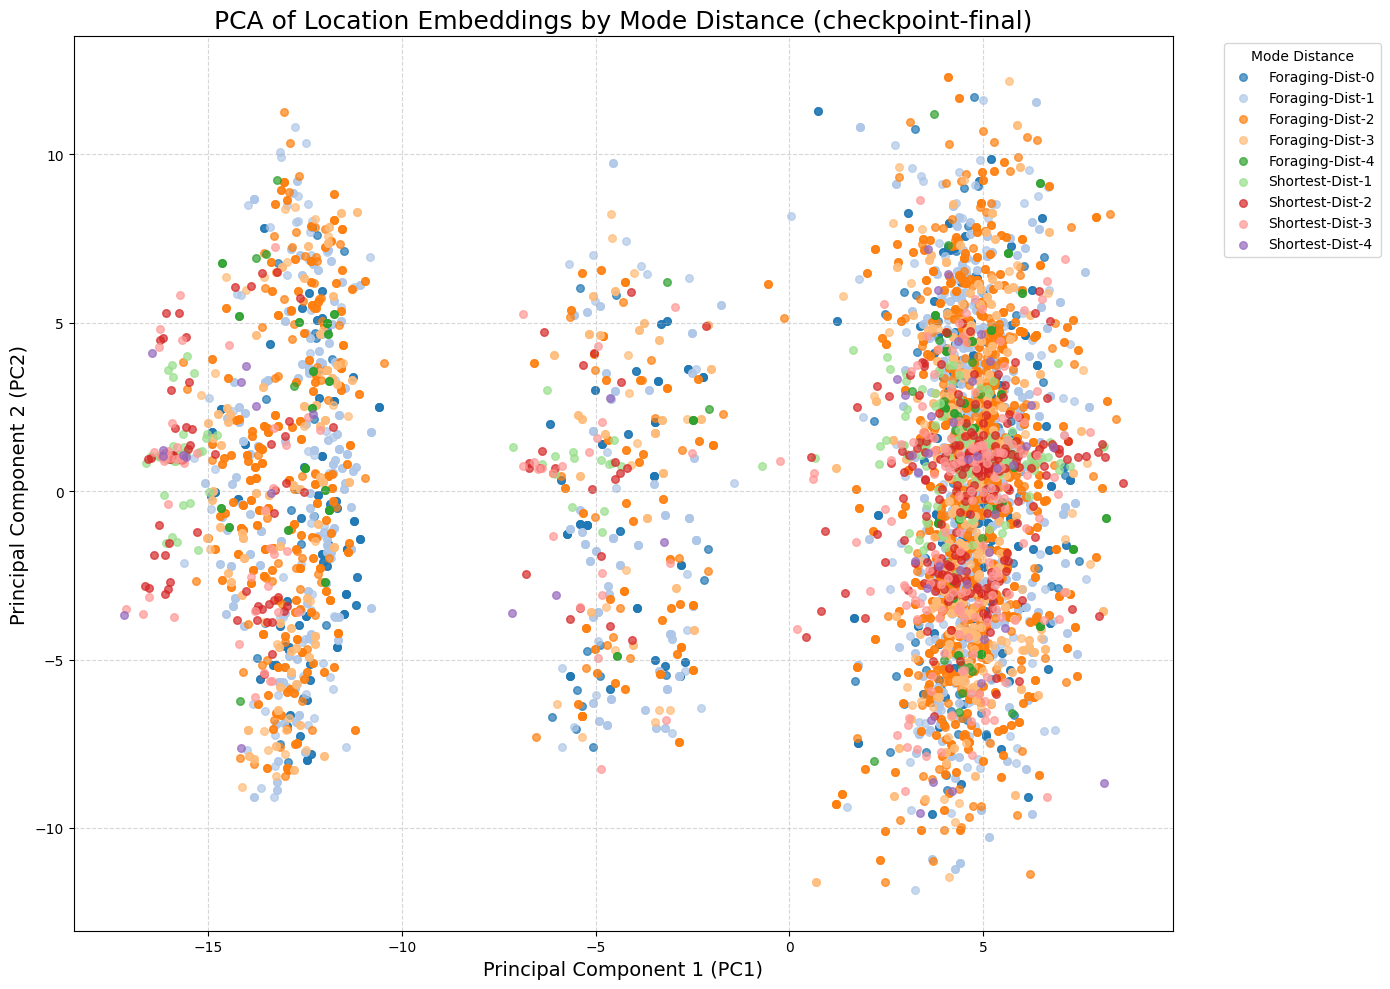

2025-07-14 01:05:04,449 - INFO - Full analysis completed.


In [64]:
import random
import string
import torch
import numpy as np
import networkx as nx
import logging
import os

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Set up logging to only show INFO level messages and higher
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define the paths to your models.
# Make sure the paths are correct for your environment.
model_paths = {
    "gpt2-base": "gpt2",
    "checkpoint-mid": "spatial_model/checkpoint-22355",
    "checkpoint-final": "spatial_model/checkpoint-44659"
}


class GPTWrapper:
    """Handles loading the model and tokenizer and extracting hidden states."""
    def __init__(self, model_name='gpt2'):
        logging.info(f"Loading model: {model_name}")
        path = model_paths.get(model_name, model_name)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(path)
        self.model = GPT2LMHeadModel.from_pretrained(path, output_hidden_states=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        logging.info("Model and tokenizer loaded successfully.")

    def get_hidden_states_with_offsets(self, prompt, layer_idx):
        enc = self.tokenizer(prompt,
                             return_tensors="pt",
                             truncation=True,
                             return_offsets_mapping=True)
        with torch.no_grad():
            out = self.model(**enc)
        hidden_states = out.hidden_states[layer_idx].squeeze(0).detach().numpy()
        offsets = enc["offset_mapping"][0].tolist()
        return hidden_states, offsets

def substring_positions(haystack, needle):
    """Finds all start and end positions of a substring in a string."""
    result = []
    start = 0
    while True:
        idx = haystack.find(needle, start)
        if idx == -1:
            break
        result.append([idx, idx + len(needle)])
        start = idx + 1
    return result

def gather_embeddings_for_span(offsets, hidden_states, span):
    """
    Averages the embeddings of tokens that overlap with a given character span.
    Also returns the average index of the overlapping tokens.
    """
    (start_needed, end_needed) = span
    overlap_vecs = []
    overlap_indices = []
    for i, (start_off, end_off) in enumerate(offsets):
        if not (end_off <= start_needed or start_off >= end_needed):
            overlap_vecs.append(hidden_states[i])
            overlap_indices.append(i)
    if not overlap_vecs:
        return None, None
    averaged_vec = np.mean(overlap_vecs, axis=0)
    average_idx = np.mean(overlap_indices)
    return averaged_vec, average_idx


def generate_name() -> str:
    """Generates a random two-character name for a node."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def get_grid_graph_3x3(nodes=None):
    """Creates a 3x3 directed grid graph."""
    if nodes is None:
        nodes = [generate_name() for _ in range(9)]
    G = nx.DiGraph()
    grid_indices = np.arange(9).reshape(3,3)
    for r in range(3):
        for c in range(3):
            current_node = nodes[grid_indices[r,c]]
            G.add_node(current_node)
            if c < 2: # East
                neighbor = nodes[grid_indices[r, c+1]]
                G.add_edge(current_node, neighbor, direction='R'); G.add_edge(neighbor, current_node, direction='L')
            if r < 2: # South
                neighbor = nodes[grid_indices[r+1, c]]
                G.add_edge(current_node, neighbor, direction='D'); G.add_edge(neighbor, current_node, direction='U')
    return G, nodes

def build_positions_3x3(node_names):
    """Maps node names to (row, col) grid coordinates."""
    return {node_names[i]: (i // 3, i % 3) for i in range(9)}

def get_manhattan_distance(pos1, pos2):
    """Calculates the Manhattan distance between two (row, col) coordinates."""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def generate_task_prompt(G, node_names):
    """Generates a prompt with a randomly chosen mode (Shortest or Foraging)."""
    mode = random.choice(["Shortest", "Foraging"])
    start_node, end_node_goal = random.sample(node_names, 2)
    
    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node_goal)
        except nx.NetworkXNoPath:
            return None, None, None
    else: # Foraging mode
        path_nodes = [start_node]
        current_node = start_node
        for _ in range(random.randint(10, 20)): # Generate a longer random walk
            neighbors = list(G.successors(current_node))
            if len(path_nodes) > 1 and len(neighbors) > 1:
                neighbors = [n for n in neighbors if n != path_nodes[-2]] # Avoid immediate backtracking
            if not neighbors: break
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        end_node_goal = path_nodes[-1] # For foraging, the end goal is just the end of the walk

    # Create the path string with simplified options block
    options_str = "[U D L R]" # A dummy placeholder is sufficient
    path_str_parts = [start_node, options_str]
    for i in range(len(path_nodes) - 1):
        u, v = path_nodes[i], path_nodes[i+1]
        direction = G.edges[(u, v)]['direction']
        path_str_parts.append(direction)
        path_str_parts.append(v)
    
    path_as_string = " ".join(path_str_parts)
    prompt = f"MODE: {mode}, START: {start_node}, END: {end_node_goal}, PATH: {path_as_string}"
    return prompt, path_nodes, mode, start_node, end_node_goal

def gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states):
    """Gathers embeddings and their average token indices for locations."""
    loc_data_by_role = {}
    for i, loc in enumerate(path_nodes):
        role = 'First' if i == 0 else 'End' if i == len(path_nodes) - 1 else 'Intermediate'
        pos_list = substring_positions(prompt, loc)
        found_data = []
        for s, e in pos_list:
            emb, avg_idx = gather_embeddings_for_span(offsets, hidden_states, (s, e))
            if emb is not None:
                found_data.append((emb, avg_idx))
        if found_data:
            vecs, idxs = zip(*found_data)
            avg_vec = np.mean(vecs, axis=0)
            avg_idx = np.mean(idxs)
            # Use a unique key for each mention to avoid overwriting
            loc_data_by_role[f"{loc}_{i}"] = {'vec': avg_vec, 'idx': avg_idx, 'role': role, 'name': loc}
    return loc_data_by_role


def plot_by_property(all_points, model_name, reducer="pca", color_by='mode_distance'):
    """
    Performs PCA/UMAP and plots the results, colored by a specified property.
    """
    if not all_points:
        logging.error("No data to plot.")
        return

    logging.info(f"Plotting {reducer.upper()} for {model_name}, colored by '{color_by}'.")
    X = np.array([pt['vector'] for pt in all_points])
    
    dim_red = PCA(n_components=2) if reducer.lower() == "pca" else UMAP(n_components=2, random_state=42)
    X_2d = dim_red.fit_transform(X)

    plt.figure(figsize=(14, 10))
    
    grouping_key = color_by
    groups = sorted(list(set(pt[grouping_key] for pt in all_points)), key=lambda x: (x.split('-')[0], int(x.split('-')[-1])))

    # Use a diverse and visually distinct colormap
    cmap = plt.get_cmap("tab20")
    color_map = {group: cmap(i % 20) for i, group in enumerate(groups)}
    legend_title = grouping_key.replace('_', ' ').title()

    for group in groups:
        # Get indices of points belonging to the current group
        group_indices = [i for i, p in enumerate(all_points) if p.get(grouping_key) == group]
        if not group_indices: continue
        
        plt.scatter(X_2d[group_indices, 0], X_2d[group_indices, 1], 
                    color=color_map.get(group), alpha=0.7, s=30, label=str(group))
    
    plt.title(f'PCA of Location Embeddings by {legend_title} ({model_name})', fontsize=18)
    plt.xlabel('Principal Component 1 (PC1)', fontsize=14)
    plt.ylabel('Principal Component 2 (PC2)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title=legend_title, fontsize=10, bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    
    filename = f'{model_name}_pca_colored_by_{color_by}.png'
    plt.savefig(filename, dpi=300)
    logging.info(f"Saved plot as {filename}")
    plt.show()


def run_full_analysis(
    model_name="checkpoint-final",
    layer_idx=6,
    num_prompts=600, # Increased prompts for better coverage
    reducer="pca"
):
    logging.info(f"Starting full analysis for model: {model_name}")
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 50 == 0: logging.info(f"Processing prompt {i+1}/{num_prompts}...")
            
        G, node_names = get_grid_graph_3x3()
        prompt_data = generate_task_prompt(G, node_names)
        if not prompt_data: continue
        prompt, path_nodes, mode, start_node, end_node_goal = prompt_data
            
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        loc_data = gather_embeddings_by_role_in_prompt(prompt, path_nodes, offsets, hidden_states)

        grid_positions_mapping = build_positions_3x3(node_names)
        start_pos = grid_positions_mapping[start_node]
        end_pos = grid_positions_mapping[end_node_goal]
        manhattan_dist = get_manhattan_distance(start_pos, end_pos)

        for _, data_point in loc_data.items():
            mode_dist_property = f"{mode}-Dist-{manhattan_dist}"
            d = {
                'vector': data_point['vec'],
                'task_mode': mode,
                'positional_role': data_point['role'],
                'token_index': data_point['idx'],
                'manhattan_distance': manhattan_dist,
                'mode_distance': mode_dist_property # The key property for this experiment
            }
            all_points.append(d)

    # Plot colored by our new combined property
    plot_by_property(all_points, model_name, reducer=reducer, color_by='mode_distance')
    
    logging.info("Full analysis completed.")


if __name__ == "__main__":
    model_to_analyze = "checkpoint-final"
    run_full_analysis(
        model_name=model_to_analyze,
        layer_idx=6,
        num_prompts=600,
        reducer="pca"
    )

In [65]:
# %% [markdown]
# ### Analysis on 4x4 Grids with Training-Data-Matched Prompts
# 
# This section extends the analysis to 4x4 grids, which more closely resemble the complexity of the training data. The key improvements are:
# 
# 1.  **4x4 Grid Generation**: New functions create a 16-node grid and determine the topological role of each node (corner, edge, or inner).
# 2.  **Realistic Prompt Generation**: The prompt generation function is updated to precisely match the training data format, including the `[U D L NA]` movement options string.
# 3.  **Multi-Faceted Analysis**: We will generate three separate PCA plots to visualize how the model's representations are organized based on:
#     *   **Task Mode**: Are "Shortest" and "Foraging" paths represented differently?
#     *   **Positional Role**: Does the model differentiate between the start, intermediate, and end nodes of a path?
#     *   **Topological Role**: Does the model have a representation for a location's fixed position on the grid (e.g., a corner vs. the center)?
# 
# This comprehensive analysis will provide deeper insights into the geometric and functional knowledge encoded in the model's hidden states.

# %%
# First, let's update the model paths to point to our newly trained models.
# We will analyze the foraging model as it was trained on more complex paths.
# model_paths = {
#     "gpt2-base": "gpt2",
#     "shortest_model": "./shortest_model",
#     "foraging_model": "./foraging_model"
# }

set_seed(42)

# %%
# =============================================================================
# CELL 7: UTILITIES FOR 4x4 GRID ANALYSIS
# =============================================================================

from wonderwords import RandomWord
w = RandomWord()

def get_grid_graph_4x4():
    """Creates a 4x4 directed grid graph with unique noun-based names."""
    nodes = [w.word(include_parts_of_speech=["noun"]).replace(" ", "_") for _ in range(16)]
    G = nx.DiGraph()
    grid_indices = np.arange(16).reshape(4, 4)
    for r in range(4):
        for c in range(4):
            current_node = nodes[grid_indices[r, c]]
            G.add_node(current_node)
            if c < 3:  # East
                neighbor = nodes[grid_indices[r, c + 1]]
                G.add_edge(current_node, neighbor, direction='R')
                G.add_edge(neighbor, current_node, direction='L')
            if r < 3:  # South
                neighbor = nodes[grid_indices[r + 1, c]]
                G.add_edge(current_node, neighbor, direction='D')
                G.add_edge(neighbor, current_node, direction='U')
    return G, nodes

def build_positions_4x4(node_names):
    """Maps 4x4 node names to (row, col) grid coordinates."""
    return {node_names[i]: (i // 4, i % 4) for i in range(16)}

def get_topological_role_4x4(position):
    """Determines the topological role (corner, edge, inner) for a 4x4 grid."""
    r, c = position
    if r in {0, 3} and c in {0, 3}:
        return 'corner'
    if r in {0, 3} or c in {0, 3}:
        return 'edge'
    return 'inner'

def get_movement_options_string(G, start_node, node_positions):
    """Generates the '[U D L R]' options string based on valid moves."""
    pos = node_positions[start_node]
    options = {"U": "NA", "D": "NA", "L": "NA", "R": "NA"}
    for neighbor in G.successors(start_node):
        direction = G.edges[(start_node, neighbor)]['direction']
        options[direction] = direction
    return f"[{' '.join(options.values())}]"

def generate_4x4_task_prompt(G, node_names, node_positions):
    """
    Generates a realistic prompt for a 4x4 grid, matching the training data format.
    """
    mode = random.choice(["Shortest", "Foraging"])
    start_node, end_node = random.sample(node_names, 2)

    # Generate the path based on the mode
    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
        except nx.NetworkXNoPath:
            return None, None, None
    else:  # Foraging mode: generate a longer, non-optimal random walk
        path_nodes = [start_node]
        current_node = start_node
        # Aim for a path length between 5 and 15 steps for variety
        for _ in range(random.randint(5, 15)):
            neighbors = list(G.successors(current_node))
            if not neighbors: break
            # Simple random walk without backtracking
            if len(path_nodes) > 1 and len(neighbors) > 1:
                if path_nodes[-2] in neighbors:
                    neighbors.remove(path_nodes[-2])
            
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        
        # The prompt's end_node is the actual end of the generated path
        end_node = path_nodes[-1]
        if start_node == end_node: # Avoid trivial paths
             return None, None, None


    # Build the path string in the specified format
    options_str = get_movement_options_string(G, start_node, node_positions)
    path_str_parts = [start_node, options_str]
    for i in range(len(path_nodes) - 1):
        u, v = path_nodes[i], path_nodes[i + 1]
        direction = G.edges[(u, v)]['direction']
        path_str_parts.append(direction)
        # In this analysis, we don't use "FORGOT", so we always add the node name
        path_str_parts.append(v)
    
    path_as_string = " ".join(path_str_parts)
    prompt = f"MODE: {mode}, START: {start_node}, END: {end_node}, PATH: {path_as_string}"
    
    return prompt, path_nodes, mode


# %%
# =============================================================================
# CELL 8: MAIN ANALYSIS FUNCTION FOR 4x4 GRIDS
# =============================================================================

def run_4x4_analysis(
    model_name="foraging_model",
    layer_idx=6,
    num_prompts=200,
    reducer="pca"
):
    """Main function to run the entire analysis pipeline for 4x4 grids."""
    logging.info(f"Starting 4x4 grid analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 25 == 0:
            logging.info(f"Processing prompt {i+1}/{num_prompts}...")
            
        # 1. Generate a new 4x4 graph and a task-specific prompt
        G, node_names = get_grid_graph_4x4()
        node_positions = build_positions_4x4(node_names)
        prompt, path_nodes, mode = generate_4x4_task_prompt(G, node_names, node_positions)
        if not prompt:
            continue
            
        # 2. Get hidden states
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        
        # 3. Gather embeddings for each unique node in the path
        unique_nodes_in_path = sorted(list(set(path_nodes)), key=path_nodes.index)
        for idx, node in enumerate(unique_nodes_in_path):
            pos_list = substring_positions(prompt, node)
            vecs = [gather_embeddings_for_span(offsets, hidden_states, span) for span in pos_list]
            vecs = [v for v in vecs if v is not None]
            if not vecs: continue

            # Average embeddings if a node appears multiple times
            final_vec = np.mean(vecs, axis=0)

            # Determine the node's positional role in this specific path
            if node == path_nodes[0]:
                positional_role = 'Start'
            elif node == path_nodes[-1]:
                positional_role = 'End'
            else:
                positional_role = 'Intermediate'
            
            # 4. Store all properties for plotting
            grid_pos = node_positions[node]
            d = {
                'node_name': node,
                'vector': final_vec,
                'task_mode': mode,
                'positional_role': positional_role,
                'topological_role': get_topological_role_4x4(grid_pos),
            }
            all_points.append(d)

    # 5. Generate a plot for each property
    if not all_points:
        logging.error("Failed to gather any data points. Aborting plots.")
        return
        
    plot_by_property(all_points, model_name, reducer=reducer, color_by='task_mode')
    plot_by_property(all_points, model_name, reducer=reducer, color_by='positional_role')
    plot_by_property(all_points, model_name, reducer=reducer, color_by='topological_role')
    
    logging.info("4x4 analysis completed.")


# %%
# =============================================================================
# CELL 9: EXECUTE THE 4x4 ANALYSIS
# =============================================================================
if __name__ == "__main__":
    # Select the model to test. 'foraging_model' is a good choice as it
    # saw both optimal and non-optimal path structures during training.
    model_to_analyze = "checkpoint-final"  # or "foraging_model" for the trained model
    
    # Run the full 4x4 analysis
    run_4x4_analysis(
        model_name=model_to_analyze,
        layer_idx=6,          # Middle layer of GPT-2 Small
        num_prompts=200,      # More prompts give a denser, more reliable plot
        reducer="pca"
    )

2025-07-14 01:05:04,511 - INFO - Starting 4x4 grid analysis for model: checkpoint-final
2025-07-14 01:05:04,512 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-14 01:05:04,721 - INFO - Model and tokenizer loaded successfully.


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.